# Local Histogram Equalization

This examples enhances an image with low contrast, using a method called local histogram equalization, which spreads out the most frequent intensity values in an image.

The equalized image [1] has a roughly linear cumulative distribution function for each pixel neighborhood.

The local version [2] of the histogram equalization emphasized every local graylevel variations.

References:
+ http://en.wikipedia.org/wiki/Histogram_equalization
+ http://en.wikipedia.org/wiki/Adaptive_histogram_equalization

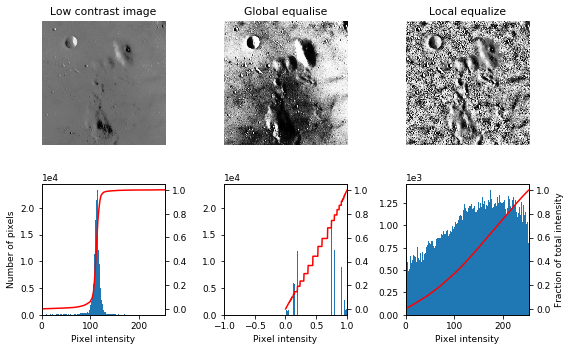

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from skimage import data
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank


matplotlib.rcParams['font.size'] = 9


def plot_img_and_hist(img, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(img, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(img.ravel(), bins=bins)
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')

    xmin, xmax = dtype_range[img.dtype.type]
    ax_hist.set_xlim(xmin, xmax)

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(img, bins)
    ax_cdf.plot(bins, img_cdf, 'r')

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = img_as_ubyte(data.moon())

# Global equalize
img_rescale = exposure.equalize_hist(img)

# Equalization
selem = disk(30)
img_eq = rank.equalize(img, selem=selem)


# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 3), dtype=np.object)
axes[0, 0] = plt.subplot(2, 3, 1, adjustable='box-forced')
axes[0, 1] = plt.subplot(2, 3, 2, sharex=axes[0, 0], sharey=axes[0, 0],
                         adjustable='box-forced')
axes[0, 2] = plt.subplot(2, 3, 3, sharex=axes[0, 0], sharey=axes[0, 0],
                         adjustable='box-forced')
axes[1, 0] = plt.subplot(2, 3, 4)
axes[1, 1] = plt.subplot(2, 3, 5)
axes[1, 2] = plt.subplot(2, 3, 6)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')
ax_hist.set_ylabel('Number of pixels')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Global equalise')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Local equalize')
ax_cdf.set_ylabel('Fraction of total intensity')


# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

# Canny edge detector

The Canny filter is a multi-stage edge detector. It uses a filter based on the derivative of a Gaussian in order to compute the intensity of the gradients.The Gaussian reduces the effect of noise present in the image. Then, potential edges are thinned down to 1-pixel curves by removing non-maximum pixels of the gradient magnitude. Finally, edge pixels are kept or removed using hysteresis thresholding on the gradient magnitude.

The Canny has three adjustable parameters: the width of the Gaussian (the noisier the image, the greater the width), and the low and high threshold for the hysteresis thresholding.

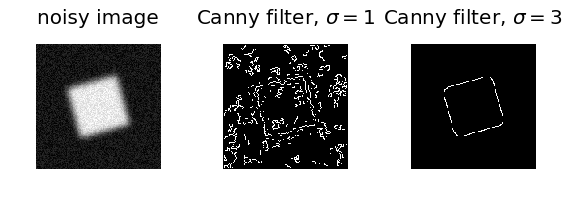

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

# Image Deconvolution

In this example, we deconvolve a noisy version of an image using Wiener and unsupervised Wiener algorithms. This algorithms are based on linear models that can’t restore sharp edge as much as non-linear methods (like TV restoration) but are much faster.

### Wiener filter

The inverse filter based on the PSF (Point Spread Function), the prior regularisation (penalisation of high frequency) and the tradeoff between the data and prior adequacy. The regularization parameter must be hand tuned.

### Unsupervised Wiener

This algorithm has a self-tuned regularisation parameters based on data learning. This is not common and based on the following publication [1]. The algorithm is based on a iterative Gibbs sampler that draw alternatively samples of posterior conditional law of the image, the noise power and the image frequency power.


[1]	François Orieux, Jean-François Giovannelli, and Thomas Rodet, “Bayesian estimation of regularization and point spread function parameters for Wiener-Hunt deconvolution”, J. Opt. Soc. Am. A 27, 1593-1607 (2010)

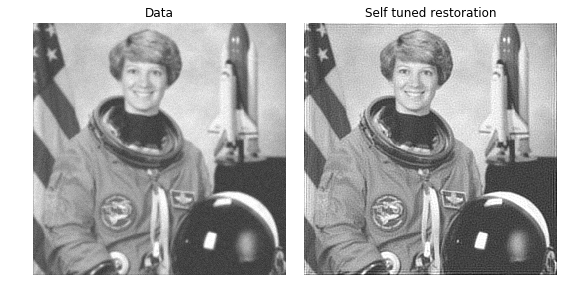

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import color, data, restoration

astro = color.rgb2gray(data.astronaut())
from scipy.signal import convolve2d as conv2
psf = np.ones((5, 5)) / 25
astro = conv2(astro, psf, 'same')
astro += 0.1 * astro.std() * np.random.standard_normal(astro.shape)

deconvolved, _ = restoration.unsupervised_wiener(astro, psf)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5),
                       sharex=True, sharey=True,
                       subplot_kw={'adjustable': 'box-forced'})

plt.gray()

ax[0].imshow(astro, vmin=deconvolved.min(), vmax=deconvolved.max())
ax[0].axis('off')
ax[0].set_title('Data')

ax[1].imshow(deconvolved)
ax[1].axis('off')
ax[1].set_title('Self tuned restoration')

fig.tight_layout()

plt.show()


# Edge operators

Edge operators are used in image processing within edge detection algorithms. They are discrete differentiation operators, computing an approximation of the gradient of the image intensity function.

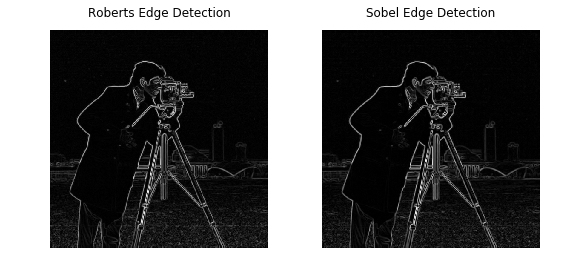

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import camera
from skimage.filters import roberts, sobel, scharr, prewitt


image = camera()
edge_roberts = roberts(image)
edge_sobel = sobel(image)

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                       figsize=(8, 4))

ax[0].imshow(edge_roberts, cmap=plt.cm.gray)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_sobel, cmap=plt.cm.gray)
ax[1].set_title('Sobel Edge Detection')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

Different operators compute different finite-difference approximations of the gradient. For example, the Scharr filter results in a less rotational variance than the Sobel filter that is in turn better than the Prewitt filter [1] [2] [3]. The difference between the Prewitt and Sobel filters and the Scharr filter is illustrated below with an image that is the discretization of a rotation- invariant continuous function. The discrepancy between the Prewitt and Sobel filters, and the Scharr filter is stronger for regions of the image where the direction of the gradient is close to diagonal, and for regions with high spatial frequencies. For the example image the differences between the filter results are very small and the filter results are visually almost indistinguishable.

[1]	https://en.wikipedia.org/wiki/Sobel_operator#Alternative_operators

[2]	B. Jaehne, H. Scharr, and S. Koerkel. Principles of filter design. In Handbook of Computer Vision and Applications. Academic Press, 1999.

[3]	https://en.wikipedia.org/wiki/Prewitt_operator

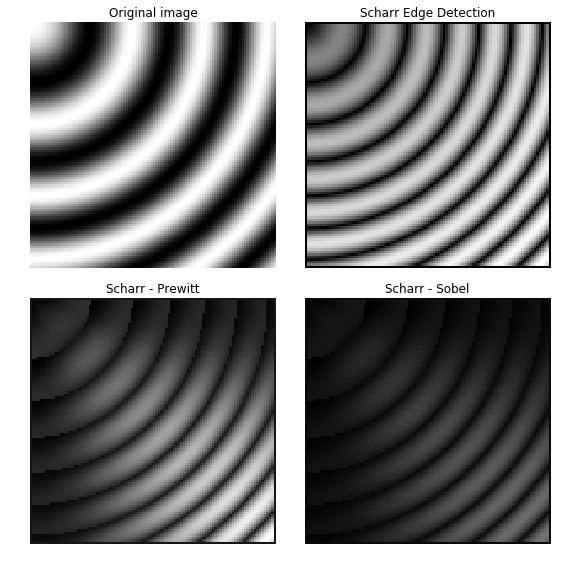

In [10]:
x, y = np.ogrid[:100, :100]
# Rotation-invariant image with different spatial frequencies
img = np.exp(1j * np.hypot(x, y)**1.3 / 20.).real

edge_sobel = sobel(img)
edge_scharr = scharr(img)
edge_prewitt = prewitt(img)

diff_scharr_prewitt = edge_scharr - edge_prewitt
diff_scharr_sobel = edge_scharr - edge_sobel
max_diff = np.max(np.maximum(diff_scharr_prewitt, diff_scharr_sobel))

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True,
                         figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(edge_scharr, cmap=plt.cm.gray)
ax[1].set_title('Scharr Edge Detection')

ax[2].imshow(diff_scharr_prewitt, cmap=plt.cm.gray, vmax=max_diff)
ax[2].set_title('Scharr - Prewitt')

ax[3].imshow(diff_scharr_sobel, cmap=plt.cm.gray, vmax=max_diff)
ax[3].set_title('Scharr - Sobel')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()